<a href="https://colab.research.google.com/github/theabhinav0231/dive_into_deep_learning_book/blob/main/08_3_NiN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfull

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## **Network in Network (NiN)**

LeNet, AlexNet, and VGG share a common structure: they extract spatial features via convolution and pooling layers, followed by fully connected layers for processing. While AlexNet and VGG improved LeNet by widening and deepening these modules, they introduced challenges:

- High Parameter Usage: Fully connected layers require vast memory, making models like VGG-11 computationally expensive, especially for mobile and embedded devices with limited RAM.
- Limited Nonlinearity Addition: Adding fully connected layers earlier disrupts spatial structure and increases memory demand.

Network-in-Network (NiN) blocks address these issues by:

- Using 1×1 convolutions to add local nonlinearities.
- Employing global average pooling to summarize spatial representations efficiently. This approach reduces memory usage while maintaining spatial structure and effectiveness.

The inputs and outputs of convolutional layers consist
of four-dimensional tensors with axes corresponding to the example, channel, height, and width.

The inputs and outputs of fully connected layers are typically twodimensional
tensors corresponding to the example and feature.

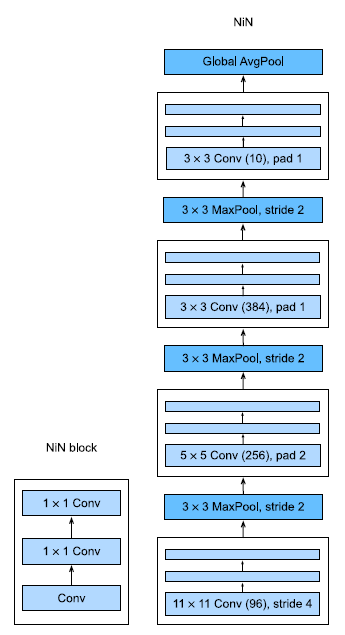


NiN follows AlexNet's initial convolution sizes (11×11, 5×5, 3×3) and output channel counts. Each NiN block is paired with a 3×3 max-pooling layer (stride 2).

Key differences from AlexNet and VGG:

- No Fully Connected Layers: Instead, NiN uses a final NiN block with output channels equal to label classes, followed by global average pooling to produce logits.
- Efficiency: This design drastically reduces model parameters but may increase training time.

In [2]:
# NiN block
def nin_block(out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.LazyConv2d(out_channels, kernel_size, strides, padding),
      nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size=1),
      nn.ReLU(),
      nn.LazyConv2d(out_channels, kernel_size=1),
      nn.ReLU()
  )

In [3]:
class NiN(d2l.Classifier):
  def __init__(self, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(
      nin_block(96, kernel_size=11, strides=4, padding=0),
      nn.MaxPool2d(3, stride=2),
      nin_block(256, kernel_size=5, strides=1, padding=2),
      nn.MaxPool2d(3, stride=2),
      nin_block(384, kernel_size=3, strides=1, padding=1),
      nn.MaxPool2d(3, stride=2),
      nn.Dropout(0.5),
      nin_block(num_classes, kernel_size=3, strides=1, padding=1),
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten()
      )
    self.net.apply(d2l.init_cnn)

In [5]:
NiN().layer_summary((1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## **Training**

In [ ]:
model = NiN(lr=0.05)
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

100%|██████████| 26.4M/26.4M [00:01<00:00, 20.3MB/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 338kB/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.46MB/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.19MB/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
